# Computer Exercise 3: Optimization (training) of neural networks

In this codelab, we will review techniques for optimization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. Specifically, we focus on optimization, comparing the optimizers SGD, SGD with Momentum, and Adam.

Credits: This material is heavily based on a [notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html#) from the University of Amsterdam.

Let's start with importing our standard libraries.

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

We will use the same `set_seed` function as in the Pytorch computer exercise, as well as the path variables `DATASET_PATH` and `CHECKPOINT_PATH`. Adjust the paths if necessary.

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial4"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In the last part of the notebook, we will train models using three different optimizers. The pretrained models for those are downloaded below.

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Preparation

Throughout this notebook, we will use a deep fully connected network, which will be applied to the [FashionMNIST dataset](https://en.wikipedia.org/wiki/Fashion_MNIST).
We start by loading the FashionMNIST dataset:

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



The normalization is designed to give us an expected mean of 0 and a standard deviation of 1 across pixels. We can calculate the normalization parameters by determining the mean and standard deviation on the original images:

In [ ]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.2860405743122101
Std 0.3530242443084717


We can verify the transformation by looking at the statistics of a single batch:

In [ ]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


Next, we create a linear neural network.

In [ ]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

## Optimization

Besides initialization, selecting a suitable optimization algorithm can be an important choice for deep neural networks. Before taking a closer look at them, we should define code for training the models.

In [ ]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")


def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        results = {}
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")


            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
                results['test_acc'] = val_acc

    results["train_scores"] = train_scores
    results["val_scores"] = val_scores
    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

First, we need to understand what an optimizer actually does. The optimizer is responsible to update the network parameters given the gradients. Hence, we effectively implement a function $w^{t} = f(w^{t-1}, g^{t}, ...)$ with $w$ being the parameters, and $g^{t} = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)}$ the gradients at time step $t$. A common, additional parameter to this function is the learning rate, here denoted by $\eta$. Usually, the learning rate can be seen as the "step size" of the update. A higher learning rate means that we change the weights more in the direction of the gradients, a smaller means we take shorter steps.

As most optimizers only differ in the implementation of $f$, we can define a template for an optimizer in PyTorch below. We take as input the parameters of a model and a learning rate. The function `zero_grad` sets the gradients of all parameters to zero, which we have to do before calling `loss.backward()`. Finally, the `step()` function tells the optimizer to update all weights based on their gradients. The template is setup below:

In [ ]:
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

The first optimizer we are going to implement is the standard Stochastic Gradient Descent (SGD). SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

As simple as the equation is also our implementation of SGD:

In [ ]:
class SGD(OptimizerTemplate):

    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

In the momentum based optimizers, the momentum replaces the gradient in the update by an exponential average of all past gradients including the current one:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

Let's also implement it below:

In [ ]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

Finally, we arrive at Adam. Adam combines the idea of momentum with an adaptive learning rate, which is based on an exponential average of the squared gradients, i.e. the gradients norm. Furthermore, we add a bias correction for the momentum and adaptive learning rate for the first iterations:

$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    v^{(t)} & = \beta_2 v^{(t-1)} + (1 - \beta_2)\cdot \left(g^{(t)}\right)^2\\
    \hat{m}^{(t)} & = \frac{m^{(t)}}{1-\beta^{t}_1}, \hat{v}^{(t)} = \frac{v^{(t)}}{1-\beta^{t}_2}\\
    w^{(t)} & = w^{(t-1)} - \frac{\eta}{\sqrt{\hat{v}^{(t)}} + \epsilon}\circ \hat{m}^{(t)}\\
\end{split}
$$

Epsilon is a small constant used to improve numerical stability for very small gradient norms. Remember that the adaptive learning rate does not replace the learning rate hyperparameter $\eta$, but rather acts as an extra factor and ensures that the gradients of various parameters have a similar norm.

In [ ]:
class Adam(OptimizerTemplate):

    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

### Comparing optimizers on model training

After we have implemented three optimizers (SGD, SGD with momentum, and Adam), we can start to analyze and compare them.
First, we test them on how well they can optimize a neural network on the FashionMNIST dataset. We use again our linear network, this time with a ReLU activation and the kaiming initialization, which we have found before to work well for ReLU-based networks. Note that the model is over-parameterized for this task, and we can achieve similar performance with a much smaller network (for example `100,100,100`). However, our main interest is in how well the optimizer can train *deep* neural networks, hence the over-parameterization.

In [ ]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])


For a fair comparison, we train the exact same model with the same seed with the three optimizers below. Feel free to change the hyperparameters if you want (however, you have to train your own model then).

  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 59.83%, Validation accuracy: 75.38%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 79.64%, Validation accuracy: 82.10%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.48%, Validation accuracy: 84.25%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 85.11%, Validation accuracy: 85.75%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 86.30%, Validation accuracy: 85.94%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 87.09%, Validation accuracy: 86.72%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.71%, Validation accuracy: 87.59%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 88.44%, Validation accuracy: 86.63%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.98%, Validation accuracy: 86.80%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 89.50%, Validation accuracy: 87.91%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.94%, Validation accuracy: 88.72%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 90.23%, Validation accuracy: 88.14%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 90.77%, Validation accuracy: 88.38%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.94%, Validation accuracy: 87.59%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 91.11%, Validation accuracy: 81.93%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 91.32%, Validation accuracy: 89.06%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 91.97%, Validation accuracy: 88.45%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 92.03%, Validation accuracy: 89.54%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 92.54%, Validation accuracy: 87.42%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 92.61%, Validation accuracy: 89.35%


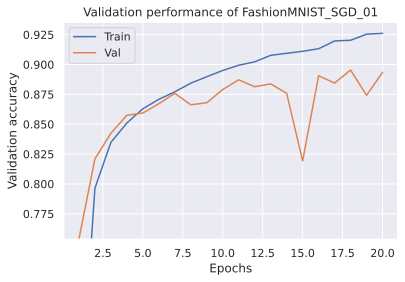

============= Test accuracy: 89.54% ==============



In [ ]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD_01",
                          lambda params: SGD(params, lr=1e-1),
                          max_epochs=20, batch_size=256)

  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 56.64%, Validation accuracy: 76.51%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 81.18%, Validation accuracy: 83.26%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 84.27%, Validation accuracy: 84.46%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 86.01%, Validation accuracy: 86.36%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 87.05%, Validation accuracy: 87.02%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 88.05%, Validation accuracy: 86.98%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 88.68%, Validation accuracy: 87.38%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 89.20%, Validation accuracy: 88.05%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 89.90%, Validation accuracy: 87.97%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 90.21%, Validation accuracy: 88.30%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 90.58%, Validation accuracy: 87.36%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 91.09%, Validation accuracy: 88.65%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 91.40%, Validation accuracy: 89.00%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 91.95%, Validation accuracy: 88.83%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 92.10%, Validation accuracy: 88.92%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 92.36%, Validation accuracy: 89.11%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 92.73%, Validation accuracy: 88.79%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 93.15%, Validation accuracy: 89.24%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 93.56%, Validation accuracy: 89.11%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 93.52%, Validation accuracy: 88.85%


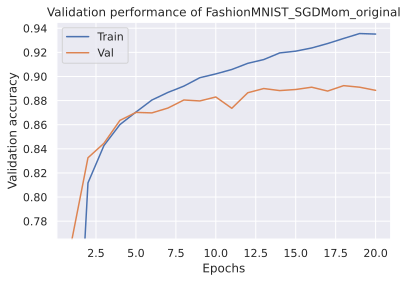

============= Test accuracy: 89.24% ==============



In [ ]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom_original",
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9),
                             max_epochs=20, batch_size=256)

  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 78.73%, Validation accuracy: 84.08%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 86.27%, Validation accuracy: 86.19%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 87.58%, Validation accuracy: 87.46%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 88.66%, Validation accuracy: 88.48%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 89.68%, Validation accuracy: 88.52%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 89.98%, Validation accuracy: 88.26%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 90.72%, Validation accuracy: 88.34%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 91.11%, Validation accuracy: 87.84%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 91.32%, Validation accuracy: 89.11%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 92.11%, Validation accuracy: 88.53%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 92.36%, Validation accuracy: 88.93%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 92.90%, Validation accuracy: 89.10%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 93.04%, Validation accuracy: 88.78%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 93.60%, Validation accuracy: 89.22%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 94.02%, Validation accuracy: 89.14%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 94.06%, Validation accuracy: 89.40%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 94.23%, Validation accuracy: 89.36%


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 94.63%, Validation accuracy: 89.43%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 94.90%, Validation accuracy: 89.60%
	   (New best performance, saving model...)


  0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 95.02%, Validation accuracy: 89.38%


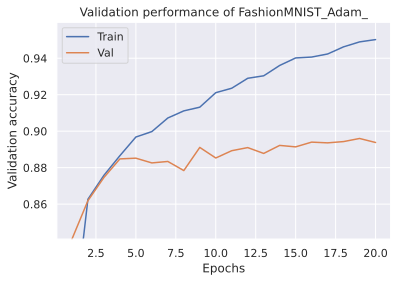

============= Test accuracy: 89.60% ==============



In [ ]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam_",
                           lambda params: Adam(params, lr=1e-3),
                           max_epochs=20, batch_size=256)

The result is that all optimizers perform similarly well with the given model. The differences are too small to find any significant conclusion. However, keep in mind that this can also be attributed to the initialization we chose. When changing the initialization to worse (e.g. constant initialization), Adam usually shows to be more robust because of its adaptive learning rate. To show the specific benefits of the optimizers, we will continue to look at some possible loss surfaces in which momentum and adaptive learning rate are crucial.

# Questions

- Analyze the effect of varying batch size and learning rate (lr). Perform a grid search for both hyperparameters and find the best ones.
- Compare SGD, SGD with Momentum and Adam. Which optimizer is the most adaptive? Should we always use it, or in some cases it may be better to use one of the others? Why?
- Explain the difference between SGD and SGD with Momentum.


You can answer the questions here:

...

### Pathological curvatures

A pathological curvature is a type of surface that is similar to ravines and is particularly tricky for plain SGD optimization. In words, pathological curvatures typically have a steep gradient in one direction with an optimum at the center, while in a second direction we have a slower gradient towards a (global) optimum. Let's first create an example surface of this and visualize it:

In [ ]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

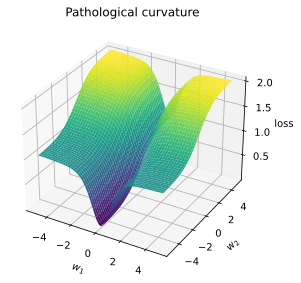

In [ ]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = plt.axes(projection='3d') if plot_3d else plt.axes()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid(x, y, indexing='xy')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In terms of optimization, you can image that $w_1$ and $w_2$ are weight parameters, and the curvature represents the loss surface over the space of $w_1$ and $w_2$. Note that in typical networks, we have many, many more parameters than two, and such curvatures can occur in multi-dimensional spaces as well.

Ideally, our optimization algorithm would find the center of the ravine and focuses on optimizing the parameters towards the direction of $w_2$. However, if we encounter a point along the ridges, the gradient is much greater in $w_1$ than $w_2$, and we might end up jumping from one side to the other. Due to the large gradients, we would have to reduce our learning rate slowing down learning significantly.

To test our algorithms, we can implement a simple function to train two parameters on such a surface:

In [ ]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

Next, let's apply the different optimizers on our curvature. Note that we set a much higher learning rate for the optimization algorithms as you would in a standard neural network. This is because we only have 2 parameters instead of tens of thousands or even millions.

In [ ]:
import torch.optim as opt

In [ ]:
SGD_points = train_curve(lambda params: opt.SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: opt.SGD(params, lr=10, momentum=0.4))
Adam_points = train_curve(lambda params: opt.Adam(params, lr=1))

To understand best how the different algorithms worked, we visualize the update step as a line plot through the loss surface. We will stick with a 2D representation for readability.

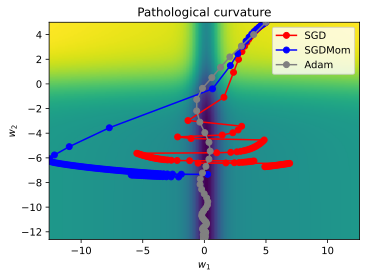

In [ ]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

We can clearly see that SGD is not able to find the center of the optimization curve and has a problem converging due to the steep gradients in $w_1$. In contrast, Adam and SGD with momentum nicely converge as the changing direction of $w_1$ is canceling itself out. On such surfaces, it is crucial to use momentum.

# Questions

- Do all optimizers converge to the minima of the proposed pathological curve? If not, which of the three optimizers is able to converge?


Optional:

- Find a different pathological curve.
- What makes pathological a curve?


# Answers
...



### Steep optima

A second type of challenging loss surfaces are steep optima. In those, we have a larger part of the surface having very small gradients while around the optimum, we have very large gradients. For instance, take the following loss surfaces:

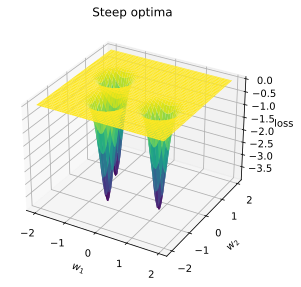

In [ ]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

Most of the loss surface has very little to no gradients. However, close to the optima, we have very steep gradients. To reach the minimum when starting in a region with lower gradients, we expect an adaptive learning rate to be crucial. To verify this hypothesis, we can run our three optimizers on the surface:

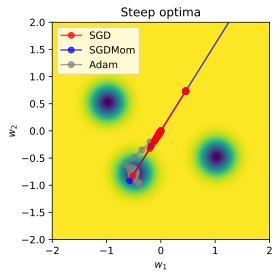

In [ ]:
SGD_points = train_curve(lambda params: opt.SGD(params, lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: opt.SGD(params, lr=1, momentum=0.9), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: opt.Adam(params, lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

SGD first takes very small steps until it touches the border of the optimum. First reaching a point around $(-0.75,-0.5)$, the gradient direction has changed and pushes the parameters to $(0.8,0.5)$ from which SGD cannot recover anymore (only with many, many steps). A similar problem has SGD with momentum, only that it continues the direction of the touch of the optimum. The gradients from this time step are so much larger than any other point that the momentum $m_t$ is overpowered by it. Finally, Adam is able to converge in the optimum showing the importance of adaptive learning rates.


# Question: What optimizer shall we choose?

- After seeing the results on optimization, what is our conclusion? Should we always use Adam and never look at SGD anymore?

# Answer

....

## Conclusion

In this tutorial, we have looked at optimization techniques for neural networks. We have seen that in optimization concepts like momentum and adaptive learning rate can help with challenging loss surfaces but don't guarantee an increase in performance for neural networks.


## References

This tutorial is based on the tutorials created by Philippe Lippe: https://github.com/phlippe/uvadlc_notebooks/

[1] Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." Proceedings of the thirteenth international conference on artificial intelligence and statistics. 2010. [link](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

[2] He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015. [link](https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html)

[3] Kingma, Diederik P. & Ba, Jimmy. "Adam: A Method for Stochastic Optimization." Proceedings of the third international conference for learning representations (ICLR). 2015. [link](https://arxiv.org/abs/1412.6980)

[4] Keskar, Nitish Shirish, et al. "On large-batch training for deep learning: Generalization gap and sharp minima." Proceedings of the fifth international conference for learning representations (ICLR). 2017. [link](https://arxiv.org/abs/1609.04836)

[5] Wilson, Ashia C., et al. "The Marginal Value of Adaptive Gradient Methods in Machine Learning." Advances in neural information processing systems. 2017. [link](https://papers.nips.cc/paper/7003-the-marginal-value-of-adaptive-gradient-methods-in-machine-learning.pdf)

[6] Ruder, Sebastian. "An overview of gradient descent optimization algorithms." arXiv preprint. 2017. [link](https://arxiv.org/abs/1609.04747)